# Open a restaurant in urban district, Hanoi
### Applied Data Science Capstone by IBM/Coursera

## Problem statement
In order to answer the question, where should a client/an investor invest to open a restaurant in urban district of Hanoi with higher chance of getting more profits and reduce the risk of being losing their money in the long-term. One of the good anwsers to this question is data science and some available software tools/algorithms. By using some analytics, some solutions can give to the clients to have a better understanding about their problems.  

## Data presentation
1. Data about each administrative unit of Hanoi is obtained from following link. ([here](https://en.wikipedia.org/wiki/Hanoi))
2. Housing price for each neighborhood in Ha noi can be found at [lease price in Hanoi](https://mogi.vn/gia-nha-dat).
3. The latitute and longitude coordination for each neighborhood can be retrieved from geopy that is a open source library using Python.

## Methodology
1. To start, the first thing to mention is, both **numpy** and **pandas** are used to manipulate the data and dataframe.
2. The next step, the administrative units of Hanoi are obtained by **scraping** the wikipedia webpage. And then, the price of housing in each district is done by scraping another website that mentioned in step 2. of Data presentation. In both cases, **Beutifulshop** from ps4 open source package are used to carried out the task.
3. In order to explore the data more convenient, some figures have been generated using the open source package like **matplotlib.pyplot**.  
4. An important metric like population density is computed and add to the data frame from the total population and area of each district.
5. In order to retreive latitude and longitude from each administrative unit of Hanoi, the **geopy.geocoders.Nominatim** is used and then two columns latitude and longitude are added to the dataframe.
6. When the collected data in data frame are fulfilled, all longitude and latitude for each district are plotted and visualized on the real map using **folium** open source package.
7. In this project, we are interested in the venues like restaurants to see how they distributed across the map of Hanoi, so the **Foursquare API** is very useful to deploy.
8. To extract the meaningful pattern of all restaurants in Hanoi, the **kMeans clusterers** (in the **sklearn.clusters** open source package) is used. To decide which number of clusters we should use, the classical method like **Elbow method** has been used and the graph show the Inertia depending on the number of clusters is presented.
9. A decision has been done based on the available data obtained after process and use aforementioned method.
10. Some notes about pros and cons that have been carried out draw a conclusion for this project

In [0]:
# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

# processing data in frame
import pandas as pd

# remove accent from Vietnamese string or name 
!pip install unidecode
from unidecode import unidecode

# numpy to use np.nan
import numpy as np

# retrieve coordination for location name
from geopy.geocoders import Nominatim
import time

# plot the coordination on maps
import folium

# convert JSON format file into a pandas dataframe
from pandas.io.json import json_normalize

# import k-means for clustering the district to find common pattern
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# District data

In [3]:
# get data from wiki table
data_hanoi_wiki = requests.get("https://en.wikipedia.org/wiki/Hanoi").text
soup = BeautifulSoup(data_hanoi_wiki, 'lxml')
table_hanoi_wiki = soup.find(name = 'span', attrs={"id" : "List_of_local_government_divisions"}).parent.next_sibling.next_sibling
table_hanoi_rows = table_hanoi_wiki.find_all('tr')
row_items = []
for row in table_hanoi_rows:
  row_td = row.find_all('td')
  row_item = [item.text for item in row_td]
  row_items.append(row_item)

# remove those rows that not having no meaningful
row_items_new = []
for row in row_items:
  if len(row) == 4:
    row_items_new.append(row)

# remove two unnecessary last rows and subtotal rows
del row_items_new[12]    
del row_items_new[-2:]

# convert to dataframe
df_hanoi = pd.DataFrame(row_items_new, columns = ['name_of_district', 'number_of_ward', 'square_km2', 'population'])

# remove HT in the end of some district name
df_hanoi['name_of_district'] = [d.replace('HT','') if d[-2:] == 'HT' else d for d in df_hanoi['name_of_district'].values ]

# remove newline characters, ',' in population and change its type to 'int'
df_hanoi['population'] = df_hanoi['population'].apply(lambda x: x.strip()).apply(lambda x: x.replace(',', '')).astype(int)

# change type column 'square_km2' to float and round off to 1 decimal
df_hanoi['square_km2'] = df_hanoi['square_km2'].astype(float).apply(lambda x: round(x,1))

# remove ward(wards) and '+' from number of wards and sum those lines if possibles
df_hanoi['number_of_ward'] = df_hanoi['number_of_ward'].apply(lambda x: x.split()).apply(lambda x: int(x[0]) if len(x)==1 else int(x[0])+int(x[2]))

# round off 0 decimal of column 'density_per_km2'
df_hanoi['density_per_km2'] = (df_hanoi['population']/df_hanoi['square_km2']).apply(lambda x: round(x))
df_hanoi['name_of_district'] = df_hanoi['name_of_district'].apply(unidecode)
df_hanoi

,name_of_district,number_of_ward,square_km2,population,density_per_km2
0,Ba Dinh,14,9.2,247100,26859
1,Bac Tu Liem,13,43.4,333300,7680
2,Cau Giay,8,12.0,266800,22233
3,Dong Da,21,10.0,420900,42090
4,Hai Ba Trung,20,10.1,318000,31485
5,Ha Dong,17,47.9,319800,6676
6,Hoan Kiem,18,5.3,160600,30302
7,Hoang Mai,14,41.0,411500,10037
8,Long Bien,14,60.4,291900,4833
9,Nam Tu Liem,10,32.3,236700,7328


# Housing price

In [4]:
# get housing price per district
data_hanoi_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(data_hanoi_price, 'lxml')
table_hanoi_price = soup.find_all(name='div', attrs={'class':'district'})[1].find_all(name='div', attrs={'class':'mt-row clearfix'}) 
hanoi_price = []
for row in table_hanoi_price:
  row_new = [i for i in row.text.strip().split('\n') if i][0:2]
  hanoi_price.append(row_new)
# create housing price frame
df_housing_price = pd.DataFrame(hanoi_price, columns=['name_of_district','housing_price_millions_VND_m2'])

# remove the word 'Quan' and 'Huyen' before name and strip vietnamese accent 
df_housing_price['name_of_district'] =df_housing_price['name_of_district'].apply(lambda x: ' '.join(x.split()[1:])).apply(unidecode)

# convert price in string to standard float value
df_housing_price['housing_price_millions_VND_m2'] = df_housing_price['housing_price_millions_VND_m2'].apply(lambda x: float(x.split()[0].replace(',','.')))
df_housing_price

,name_of_district,housing_price_millions_VND_m2
0,Ba Dinh,166.0
1,Cau Giay,144.0
2,Dong Da,167.0
3,Hai Ba Trung,147.0
4,Hoan Kiem,453.0
5,Hoang Mai,82.5
6,Long Bien,72.0
7,Tay Ho,131.0
8,Thanh Xuan,108.0
9,Ha Dong,76.7


## Merge two table into one

In [5]:
# merge housing price for each district
data_hanoi = pd.merge(df_hanoi, df_housing_price, how='left', on='name_of_district')
index_nan = [x for x in range(len(data_hanoi['housing_price_millions_VND_m2'])) if np.isnan(data_hanoi.iloc[x,5])]
data_hanoi.drop(index_nan)

# remove some districts that are low density (less than 2000 person per km2) population or larger than 100 km2
index_drop = data_hanoi[(data_hanoi['square_km2'] > 100) | (data_hanoi['density_per_km2'] < 2000)].index
data_hanoi.drop(index_drop, inplace=True)
data_hanoi.reset_index(drop=True, inplace=True)
data_hanoi

,name_of_district,number_of_ward,square_km2,population,density_per_km2,housing_price_millions_VND_m2
0,Ba Dinh,14,9.2,247100,26859,166.0
1,Bac Tu Liem,13,43.4,333300,7680,72.4
2,Cau Giay,8,12.0,266800,22233,144.0
3,Dong Da,21,10.0,420900,42090,167.0
4,Hai Ba Trung,20,10.1,318000,31485,147.0
5,Ha Dong,17,47.9,319800,6676,76.7
6,Hoan Kiem,18,5.3,160600,30302,453.0
7,Hoang Mai,14,41.0,411500,10037,82.5
8,Long Bien,14,60.4,291900,4833,72.0
9,Nam Tu Liem,10,32.3,236700,7328,76.8


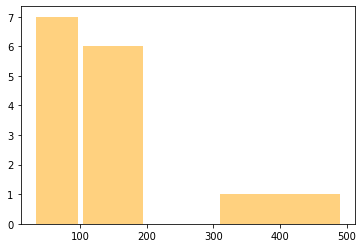

In [6]:
# plot the histogram for range of price
hist, bin_edges = np.histogram(data_hanoi['housing_price_millions_VND_m2'], bins = [30, 100, 200, 300, 500] )
plt.hist(data_hanoi['housing_price_millions_VND_m2'], bins=bin_edges, facecolor='orange', alpha=0.5, rwidth=0.9)
plt.show()

### The range of price are assigned based on their values as follows:
   - Low price (LOW): 0 <= price <= 100
   - Medium price (MEDIUM): 100 < price <= 200
   - High price (HIGH): 200 < price <= 300
   - Very high price (EXTREME): price > 300


In [7]:
# assign label for its range of price
def label_price(price):
  if 0 < price <= 100:
    return 'LOW'
  elif  100 < price <= 200:
    return 'MEDIUM'
  elif  200 < price <= 300:
    return 'HIGH'
  elif  price > 300:
    return 'EXTREME'
  else:
    return 'Your price can not be negative'

# create another column in the data_hanoi
data_hanoi['price_label'] = data_hanoi['housing_price_millions_VND_m2'].apply(label_price)
data_hanoi

,name_of_district,number_of_ward,square_km2,population,density_per_km2,housing_price_millions_VND_m2,price_label
0,Ba Dinh,14,9.2,247100,26859,166.0,MEDIUM
1,Bac Tu Liem,13,43.4,333300,7680,72.4,LOW
2,Cau Giay,8,12.0,266800,22233,144.0,MEDIUM
3,Dong Da,21,10.0,420900,42090,167.0,MEDIUM
4,Hai Ba Trung,20,10.1,318000,31485,147.0,MEDIUM
5,Ha Dong,17,47.9,319800,6676,76.7,LOW
6,Hoan Kiem,18,5.3,160600,30302,453.0,EXTREME
7,Hoang Mai,14,41.0,411500,10037,82.5,LOW
8,Long Bien,14,60.4,291900,4833,72.0,LOW
9,Nam Tu Liem,10,32.3,236700,7328,76.8,LOW


# Get coodinate for each district

In [8]:
# function to retrieve coordination of each district
def get_coordination(name_district):
  string_search = name_district + ' Ha Noi Vietnam'
  coorlocator = Nominatim(user_agent="Explore_Hanoi")
  coordination = coorlocator.geocode(string_search)
 
  # prevent google fail to retrieve coordination
  try:
    latitude, longitude = coordination.latitude, coordination.longitude
  except:
    latitude, longitude = np.nan, np.nan

  return latitude, longitude

# call function to get coordination 
### ***method 1*** using list comprehension but sometimes fail
#coors = [get_coordination(district_name) for district_name in data_hanoi['name_of_district'].tolist()]

### ***method 2*** using normal for loop and add time delay 5 seconds to relax service geolocator
#coors = []
#for district_name in data_hanoi['name_of_district'].tolist():
#  print(district_name)
#  coor = get_coordination(district_name)
#  time.sleep(5)
#  coors.append(coor)
#df_coors = pd.DataFrame(coors, columns=['latitude','longitude'])
#data_hanoi['latitude'] = df_coors['latitude']
#data_hanoi['longitude'] = df_coors['longitude']
#data_hanoi.to_csv('/content/gdrive/My Drive/hanoi.csv', index=False)

Ba Dinh
Bac Tu Liem
Cau Giay
Dong Da
Hai Ba Trung
Ha Dong
Hoan Kiem
Hoang Mai
Long Bien
Nam Tu Liem
Tay Ho
Thanh Xuan
Dan Phuong
Hoai Duc
Thanh Tri


In [9]:
data_hanoi = pd.read_csv('/content/gdrive/My Drive/hanoi.csv')
data_hanoi

,name_of_district,number_of_ward,square_km2,population,density_per_km2,housing_price_millions_VND_m2,price_label,latitude,longitude
0,Ba Dinh,14,9.2,247100,26859,166.0,MEDIUM,21.036305,105.828986
1,Bac Tu Liem,13,43.4,333300,7680,72.4,LOW,21.069861,105.757339
2,Cau Giay,8,12.0,266800,22233,144.0,MEDIUM,21.027277,105.791464
3,Dong Da,21,10.0,420900,42090,167.0,MEDIUM,21.012891,105.827710
4,Hai Ba Trung,20,10.1,318000,31485,147.0,MEDIUM,21.005970,105.857484
5,Ha Dong,17,47.9,319800,6676,76.7,LOW,20.952443,105.760955
6,Hoan Kiem,18,5.3,160600,30302,453.0,EXTREME,21.028934,105.852260
7,Hoang Mai,14,41.0,411500,10037,82.5,LOW,20.975951,105.842097
8,Long Bien,14,60.4,291900,4833,72.0,LOW,21.039341,105.892245
9,Nam Tu Liem,10,32.3,236700,7328,76.8,LOW,21.012846,105.760875


## Plot coordinations on the map to verify their locations

In [10]:
# get the coordination center of Hanoi city
lat_hn, long_hn = get_coordination('Ha Noi Vietnam')
print('The center coordination of Hanoi are: latitude_hanoi = {}, and longtitude_hanoi = {}'.format(lat_hn, long_hn))

The center coordination of Hanoi are: latitude_hanoi = 21.007196399999998, and longtitude_hanoi = 105.53142761311506


In [11]:
hn_map = folium.Map(location=[lat_hn, long_hn], zoom_start=10)
for lati, longi, dis in zip(data_hanoi['latitude'], data_hanoi['longitude'], data_hanoi['name_of_district']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, longi],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(hn_map)  

hn_map

#Some pre-defined functions for extract venues

In [12]:
# Define foursquare API credential to use API
CLIENT_ID = 'MC2SRBWTQ4OJXCCA1KUMROH2SOVUVP103QMRIRDMPJHEPGNK' # Foursquare ID
CLIENT_SECRET = 'IFMJISV3YMKFQI1WTGAUAKTKPQ3EUPBOO4J2BQ55Z1M1WRQY' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# define function to get all venues nearby 
def getNearbyVenues(names, latitudes, longitudes, radius=1600, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['district', 
                  'district Latitude', 
                  'district Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Your credentails:
CLIENT_ID: MC2SRBWTQ4OJXCCA1KUMROH2SOVUVP103QMRIRDMPJHEPGNK
CLIENT_SECRET:IFMJISV3YMKFQI1WTGAUAKTKPQ3EUPBOO4J2BQ55Z1M1WRQY


### Call getnearby functions to get all venues in the range of 1500 meters from the center

In [13]:
# get venues from center of each district
hanoi_venues = getNearbyVenues(names=data_hanoi['name_of_district'],
                             latitudes=data_hanoi['latitude'],
                             longitudes=data_hanoi['longitude']
                            )

Ba Dinh
Bac Tu Liem
Cau Giay
Dong Da
Hai Ba Trung
Ha Dong
Hoan Kiem
Hoang Mai
Long Bien
Nam Tu Liem
Tay Ho
Thanh Xuan
Dan Phuong
Hoai Duc
Thanh Tri


In [14]:
print(hanoi_venues.shape)
hanoi_venues.head()

(618, 7)


,district,district Latitude,district Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ba Dinh,21.036305,105.828986,Bia Hơi 19C Ngọc Hà,21.037280,105.831327,Beer Garden
1,Ba Dinh,21.036305,105.828986,Bình Minh,21.031457,105.832087,Fried Chicken Joint
2,Ba Dinh,21.036305,105.828986,Lý Văn Phúc (Chicken Street),21.031233,105.832014,Wings Joint
3,Ba Dinh,21.036305,105.828986,Zennova Massage,21.029979,105.825851,Massage Studio
4,Ba Dinh,21.036305,105.828986,Văn Miếu Quốc Tử Giám (Temple of Literature) (...,21.028707,105.836005,Confucian Temple


## Number of venues in each district


In [15]:
# group district to and count total number of venues in each district and comparision
total_venue_district = hanoi_venues.groupby('district').count().reset_index()
print('There are total: {} venues in all districts'.format(total_venue_district['Venue Category'].sum()))
total_venue_district

There are total: 618 venues in all districts


,district,district Latitude,district Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ba Dinh,100,100,100,100,100,100
1,Bac Tu Liem,3,3,3,3,3,3
2,Cau Giay,73,73,73,73,73,73
3,Dong Da,95,95,95,95,95,95
4,Ha Dong,7,7,7,7,7,7
5,Hai Ba Trung,93,93,93,93,93,93
6,Hoai Duc,6,6,6,6,6,6
7,Hoan Kiem,100,100,100,100,100,100
8,Hoang Mai,7,7,7,7,7,7
9,Long Bien,15,15,15,15,15,15


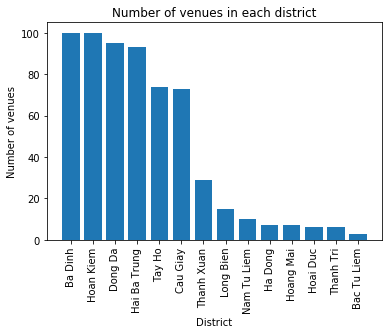

In [16]:
# plot number of venues in each district
total_venue_district.sort_values('Venue', ascending = False, inplace = True)
plt.bar(total_venue_district['district'], total_venue_district['Venue'])
plt.title('Number of venues in each district')
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('Number of venues')
plt.show()

## list of unique venues in all districts

In [17]:
# Count the unique number of venue categories in all districts
num_unique_venue = hanoi_venues['Venue Category'].unique()
print(num_unique_venue)
print('There are: {} unique venues in all districts'.format(len(num_unique_venue)))

['Beer Garden' 'Fried Chicken Joint' 'Wings Joint' 'Massage Studio'
 'Confucian Temple' 'BBQ Joint' 'Coffee Shop' 'Temple'
 'Monument / Landmark' 'Hotel' 'Rock Club' 'Vietnamese Restaurant'
 'Historic Site' 'Steakhouse' 'Hotpot Restaurant' 'Bar' 'Noodle House'
 'Palace' 'Vegetarian / Vegan Restaurant' 'Café' 'Lounge' 'Lake'
 'Buddhist Temple' 'Church' 'Sushi Restaurant' 'Wine Bar' 'Wedding Hall'
 'Art Museum' 'Ice Cream Shop' 'Food Court' 'Japanese Restaurant' 'Plaza'
 'Chinese Restaurant' 'Park' 'Satay Restaurant' 'Supermarket'
 'Himalayan Restaurant' 'History Museum' 'Castle'
 'Latin American Restaurant' 'Mongolian Restaurant' 'Bistro' 'Bakery'
 'Botanical Garden' 'Soccer Stadium' 'Pizza Place' 'Beer Bar' 'Restaurant'
 'Italian Restaurant' 'Paintball Field' 'Business Service'
 'Mobile Phone Shop' 'Shopping Mall' 'Fish & Chips Shop' 'Multiplex'
 'Malay Restaurant' 'Arepa Restaurant' 'Scenic Lookout'
 'Gym / Fitness Center' 'Korean Restaurant' 'Fast Food Restaurant'
 'Thai Restaurant' 

## number of venue categories in each district

In [18]:
# find the unique venue categories in each district
num_venue_category = (hanoi_venues.groupby(['district','Venue Category'])
                              .count().reset_index()[['district','Venue Category']].groupby('district')
                                  .count().reset_index() )
num_venue_category

,district,Venue Category
0,Ba Dinh,49
1,Bac Tu Liem,3
2,Cau Giay,32
3,Dong Da,51
4,Ha Dong,7
5,Hai Ba Trung,37
6,Hoai Duc,5
7,Hoan Kiem,34
8,Hoang Mai,7
9,Long Bien,12


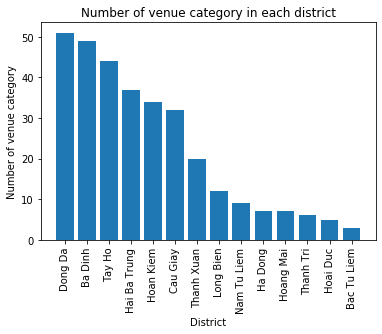

In [19]:
# plot the number of venue category in each district
num_venue_category.sort_values('Venue Category', ascending = False, inplace = True)
plt.bar(num_venue_category['district'], num_venue_category['Venue Category'])
plt.title('Number of venue category in each district')
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('Number of venue category')
plt.show()

## Find the most commone venues in each district 

In [20]:
# one hot encoding using pandas dummies
hanoi_onehot = pd.get_dummies(hanoi_venues[['Venue Category']], prefix="", prefix_sep="")

# add name of district column to dataframe
hanoi_onehot['district'] = hanoi_venues['district'] 

# move name district column to the first column for easy view
tmp_columns = [hanoi_onehot.columns[-1]] + list(hanoi_onehot.columns[:-1])
hanoi_onehot = hanoi_onehot[tmp_columns]

# group according to district and then mean() according to features (each category) to find the frequency of each category in each district
hanoi_grouped = hanoi_onehot.groupby('district').mean().reset_index()
hanoi_grouped 

,district,Arepa Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Bath House,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Betting Shop,Bistro,Bookstore,Botanical Garden,Brewery,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Burger Joint,Bus Station,Business Service,Cafeteria,Café,Campground,Castle,Chinese Restaurant,Chocolate Shop,Church,Cocktail Bar,Coffee Shop,Comic Shop,Confucian Temple,Convention Center,...,Pedestrian Plaza,Pizza Place,Plaza,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Rock Club,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Spa,Spiritual Center,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wedding Hall,Wine Bar,Wings Joint
0,Ba Dinh,0.000000,0.01,0.00,0.000000,0.0,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.01,0.000000,0.01,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.01,0.02,0.00,0.01,0.000000,0.130000,0.000000,0.01,0.000000,...,0.000000,0.020000,0.01,0.000000,0.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.0,0.020000,0.010000,0.010000,0.000000,0.000000,0.02,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.01,0.090000,0.000000,0.01,0.010000,0.01
1,Bac Tu Liem,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.333333,0.000000,0.00,0.000000,0.00
2,Cau Giay,0.013699,0.00,0.00,0.000000,0.0,0.013699,0.027397,0.027397,0.000000,0.000000,0.000000,0.013699,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.013699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136986,0.000000,0.00,0.00,0.00,0.00,0.013699,0.095890,0.000000,0.00,0.000000,...,0.000000,0.041096,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.013699,0.013699,0.027397,0.013699,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.013699,0.000000,0.013699,0.00,0.013699,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.123288,0.000000,0.00,0.000000,0.00
3,Dong Da,0.010526,0.00,0.00,0.010526,0.0,0.010526,0.021053,0.021053,0.000000,0.000000,0.000000,0.010526,0.010526,0.000000,0.000000,0.00,0.010526,0.00,0.000000,0.010526,0.00,0.000000,0.010526,0.010526,0.000000,0.000000,0.000000,0.000000,0.063158,0.000000,0.00,0.00,0.00,0.00,0.000000,0.105263,0.010526,0.00,0.010526,...,0.000000,0.042105,0.00,0.000000,0.010526,0.000000,0.010526,0.010526,0.000000,0.000000,0.010526,0.00,0.000000,0.042105,0.010526,0.000000,0.000000,0.00,0.010526,0.000000,0.000000,0.0,0.010526,0.042105,0.010526,0.000000,0.010526,0.00,0.010526,0.000000,0.000000,0.010526,0.0,0.000000,0.00,0.063158,0.000000,0.00,0.000000,0.00
4,Ha Dong,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00

In [21]:
# return most common venues in each district
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# show (say: 5 most common venues in each district)
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['district'] = hanoi_grouped['district']

for ind in np.arange(hanoi_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = most_common_venues(hanoi_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ba Dinh,Coffee Shop,Café,Vietnamese Restaurant,Hotel,Japanese Restaurant
1,Bac Tu Liem,Vietnamese Restaurant,Paintball Field,Business Service,Wings Joint,Fast Food Restaurant
2,Cau Giay,Café,Vietnamese Restaurant,Coffee Shop,Fast Food Restaurant,Japanese Restaurant
3,Dong Da,Coffee Shop,Café,Vietnamese Restaurant,Pizza Place,Seafood Restaurant
4,Ha Dong,IT Services,History Museum,Bus Station,Furniture / Home Store,Bakery
5,Hai Ba Trung,Vietnamese Restaurant,Café,Coffee Shop,Hotel,Japanese Restaurant
6,Hoai Duc,Betting Shop,Soccer Field,Rental Car Location,Campground,Lake
7,Hoan Kiem,Vietnamese Restaurant,Hotel,Coffee Shop,Café,Noodle House
8,Hoang Mai,Coffee Shop,Electronics Store,Bus Station,Café,Fast Food Restaurant
9,Long Bien,Fast Food Restaurant,Shopping Mall,Ice Cream Shop,Grocery Store,Electronics Store


# Choose only columns having name 'Restaurant'
#### Because our client is interested in open an restaurant

In [22]:
column_named_restaurant = hanoi_grouped.columns
column_name = [venue_category for venue_category in column_named_restaurant if 'Restaurant' in venue_category]
data_restaurant = hanoi_grouped[['district']+column_name]
data_restaurant

,district,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Bulgarian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Fast Food Restaurant,French Restaurant,Hainan Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,New American Restaurant,Pakistani Restaurant,Ramen Restaurant,Restaurant,Satay Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Ba Dinh,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.030000,0.000000,0.000000,0.010000,0.030000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.010000,0.01,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.090000
1,Bac Tu Liem,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.333333
2,Cau Giay,0.013699,0.000000,0.013699,0.000000,0.000000,0.00,0.00,0.068493,0.000000,0.000000,0.013699,0.00,0.000000,0.000000,0.000000,0.000000,0.054795,0.041096,0.00,0.013699,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.013699,0.013699,0.000000,0.013699,0.000000,0.00,0.123288
3,Dong Da,0.010526,0.010526,0.010526,0.000000,0.010526,0.00,0.00,0.042105,0.000000,0.000000,0.000000,0.00,0.010526,0.000000,0.000000,0.000000,0.010526,0.010526,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010526,0.010526,0.00,0.042105,0.010526,0.000000,0.010526,0.000000,0.00,0.063158
4,Ha Dong,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,Hai Ba Trung,0.010753,0.000000,0.000000,0.010753,0.000000,0.00,0.00,0.021505,0.021505,0.010753,0.010753,0.00,0.021505,0.000000,0.000000,0.010753,0.064516,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.010753,0.032258,0.000000,0.010753,0.000000,0.00,0.204301
6,Hoai Duc,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
7,Hoan Kiem,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.01,0.010000,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.180000
8,Hoang Mai,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.142857,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Long Bien,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.066667,0.000000,0.000000,0.000000,0.00,0.066667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


### show top 10 restaurants in each district

In [23]:
# show (say: 10 most common restaurant in each district)
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create column according to number of top venues
column = ['district']
for ind in np.arange(num_top_venues):
    try:
        column.append('{}{} Most restaurant'.format(ind+1, indicators[ind]))
    except:
        column.append('{}th Most restaurant'.format(ind+1))

# create a new dataframe
restaurant_sorted = pd.DataFrame(columns=column)
restaurant_sorted['district'] = data_restaurant['district']

for ind in np.arange(data_restaurant.shape[0]):
    restaurant_sorted.iloc[ind, 1:] = most_common_venues(data_restaurant.iloc[ind, :], num_top_venues)

restaurant_sorted

,district,1st Most restaurant,2nd Most restaurant,3rd Most restaurant,4th Most restaurant,5th Most restaurant,6th Most restaurant,7th Most restaurant,8th Most restaurant,9th Most restaurant,10th Most restaurant
0,Ba Dinh,Vietnamese Restaurant,Japanese Restaurant,Hotpot Restaurant,Chinese Restaurant,Mongolian Restaurant,Sushi Restaurant,Italian Restaurant,Satay Restaurant,Restaurant,Vegetarian / Vegan Restaurant
1,Bac Tu Liem,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Hainan Restaurant,French Restaurant
2,Cau Giay,Vietnamese Restaurant,Fast Food Restaurant,Japanese Restaurant,Korean Restaurant,Arepa Restaurant,Seafood Restaurant,Sushi Restaurant,Australian Restaurant,Thai Restaurant,Halal Restaurant
3,Dong Da,Vietnamese Restaurant,Fast Food Restaurant,Seafood Restaurant,Ramen Restaurant,Asian Restaurant,Australian Restaurant,Bulgarian Restaurant,Hotpot Restaurant,Japanese Restaurant,Korean Restaurant
4,Ha Dong,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Hainan Restaurant,French Restaurant
5,Hai Ba Trung,Vietnamese Restaurant,Japanese Restaurant,Sushi Restaurant,Fast Food Restaurant,French Restaurant,Hotpot Restaurant,Belgian Restaurant,Hainan Restaurant,Halal Restaurant,Italian Restaurant
6,Hoai Duc,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Hainan Restaurant,French Restaurant
7,Hoan Kiem,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Australian Restaurant,Belgian Restaurant,Bulgarian Restaurant
8,Hoang Mai,Fast Food Restaurant,Vietnamese Restaurant,Hainan Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,French Restaurant
9,Long Bien,Fast Food Restaurant,Seafood Restaurant,New American Restaurant,French Restaurant,Indonesian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Hainan Restaurant


# Use K-means to recognize how similar and dissimilar between each district 

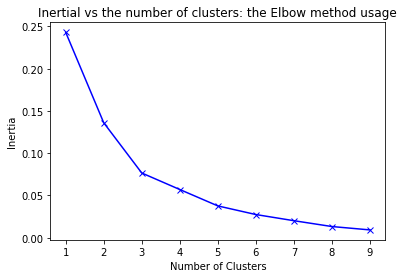

In [24]:
# try with 10 different values of k to find the best one
number_clustering = 10
Inertia = []

hanoi_restaurant = data_restaurant.drop('district', axis = 1)

for idx in range(1, number_clustering):

    # run k-means clustering
    kmeans = KMeans(n_clusters=idx, random_state=0).fit(hanoi_restaurant)

    # find the distortion w.r.t each k
    Inertia.append(kmeans.inertia_)

plt.plot(range(1, number_clustering), Inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertial vs the number of clusters: the Elbow method usage')
plt.show()

In [25]:
data_hanoi

,name_of_district,number_of_ward,square_km2,population,density_per_km2,housing_price_millions_VND_m2,price_label,latitude,longitude
0,Ba Dinh,14,9.2,247100,26859,166.0,MEDIUM,21.036305,105.828986
1,Bac Tu Liem,13,43.4,333300,7680,72.4,LOW,21.069861,105.757339
2,Cau Giay,8,12.0,266800,22233,144.0,MEDIUM,21.027277,105.791464
3,Dong Da,21,10.0,420900,42090,167.0,MEDIUM,21.012891,105.827710
4,Hai Ba Trung,20,10.1,318000,31485,147.0,MEDIUM,21.005970,105.857484
5,Ha Dong,17,47.9,319800,6676,76.7,LOW,20.952443,105.760955
6,Hoan Kiem,18,5.3,160600,30302,453.0,EXTREME,21.028934,105.852260
7,Hoang Mai,14,41.0,411500,10037,82.5,LOW,20.975951,105.842097
8,Long Bien,14,60.4,291900,4833,72.0,LOW,21.039341,105.892245
9,Nam Tu Liem,10,32.3,236700,7328,76.8,LOW,21.012846,105.760875


#### Some comments about optimum number of clusters
  - The elbow method saying that, the optimum number of cluster when the objective values is suddently changing its value.
  - Then here the optimum number of cluster is chosen 3

In [0]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters).fit(hanoi_restaurant)

In [27]:
# merge the data_hanoi with the cluster we obtained
data_summary = pd.DataFrame(list(zip(data_restaurant['district'], kmeans.labels_)), columns=['district','label'])
data_combined_summary = pd.merge(data_summary, data_hanoi, left_on = 'district', right_on = 'name_of_district', how='left')
data_combined_summary.drop(['name_of_district', 'square_km2', 'number_of_ward'], axis = 1, inplace=True)
data_combined_summary


,district,label,population,density_per_km2,housing_price_millions_VND_m2,price_label,latitude,longitude
0,Ba Dinh,2,247100,26859,166.0,MEDIUM,21.036305,105.828986
1,Bac Tu Liem,0,333300,7680,72.4,LOW,21.069861,105.757339
2,Cau Giay,2,266800,22233,144.0,MEDIUM,21.027277,105.791464
3,Dong Da,2,420900,42090,167.0,MEDIUM,21.012891,105.827710
4,Ha Dong,2,319800,6676,76.7,LOW,20.952443,105.760955
5,Hai Ba Trung,0,318000,31485,147.0,MEDIUM,21.005970,105.857484
6,Hoai Duc,2,229400,2407,44.5,LOW,21.011501,105.707686
7,Hoan Kiem,0,160600,30302,453.0,EXTREME,21.028934,105.852260
8,Hoang Mai,1,411500,10037,82.5,LOW,20.975951,105.842097
9,Long Bien,1,291900,4833,72.0,LOW,21.039341,105.892245


#### At this stage we do not know what cluster name (0, 1, and 2) mean?
  - Because we have nearly 24 types of restaurant. (according to 24 features)
  - There are so many features, then it is difficult to regconize.
  - Then, to know this district has more restaurants than the others. One simple way that can be done, we will sum all the frequent in each district.

In [34]:
# sum the data_restaurant along the row
data_combined_summary['restaurant_frequency'] = data_restaurant.sum(axis=1)
data_combined_summary.sort_values('label').reset_index(drop=True)

,district,label,population,density_per_km2,housing_price_millions_VND_m2,price_label,latitude,longitude,restaurant_frequency
0,Bac Tu Liem,0,333300,7680,72.4,LOW,21.069861,105.757339,0.333333
1,Hai Ba Trung,0,318000,31485,147.0,MEDIUM,21.005970,105.857484,0.440860
2,Hoan Kiem,0,160600,30302,453.0,EXTREME,21.028934,105.852260,0.260000
3,Hoang Mai,1,411500,10037,82.5,LOW,20.975951,105.842097,0.142857
4,Long Bien,1,291900,4833,72.0,LOW,21.039341,105.892245,0.333333
5,Nam Tu Liem,1,236700,7328,76.8,LOW,21.012846,105.760875,0.300000
6,Thanh Tri,1,256800,4050,63.9,LOW,20.941462,105.836033,0.166667
7,Ba Dinh,2,247100,26859,166.0,MEDIUM,21.036305,105.828986,0.250000
8,Cau Giay,2,266800,22233,144.0,MEDIUM,21.027277,105.791464,0.383562
9,Dong Da,2,420900,42090,167.0,MEDIUM,21.012891,105.827710,0.263158


##### From the above table, what we can draw to conclusion is:
  - cluster 0: Those districts have so many restaurants 
  - cluster 1: Those areas have less restarants than cluster 0.
  - cluster 2: Those neighborhoods have fewer restaurants

#### The dicision can be chosen based on the data above:
  - The client can invest in Hoang Mai, or Nam Tu Liem with the price for rent is low and the population density is pretty high.

#### Notes:
  - Actually, the decision and the data is highly depending on the API foursquare API, therefore, it is not accurate 100%.
  - For example, Hoai Duc and Ha Dong districts have not any restaurants, which are a bit strange. 
  - The geographical location of Hanoi is a bit not highly dense population. Indeed, the neighborhoods are distributed in many locations for some sub-urban districts. Then, to improve the sampling locations, latitude and longitude of each ward in district is needed.
